### Imports and functions

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [60]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
# from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
import matplotlib
matplotlib.rc_file_defaults()
import string

In [61]:
# def sensitivity_test(parameter,region,x_type,load,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         internal = region.compute_x(x_type=x_type,load=load,**args)
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     # dataset['MTratio'] = dataset.model_le/dataset.total_le
        
#     return dataset

In [62]:
def sensitivity_test(parameter,region,x_type,load,args):
    values = args[parameter]
    datasets = []
    for i in values:
        args[parameter] = i
        region.compute_x(x_type=x_type,load=load,**args)
        region.compute_LE()
        region.compute_FIT()
        internal = region.results
        internal = internal.squeeze()
        datasets.append(internal)
    dataset = xr.concat(datasets, dim=values)
    dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
    return dataset

In [63]:
def merge_region_variable(ds1,ds2):
    regions = ['Seattle', 'Montreal', 'Lagos']
    lats = [47.6, 45.5, 6.5]
    lons = [237.7, 286.2, 3.4]
    region_dim = xr.DataArray(regions, coords={'region': regions})

    variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
    dataset = xr.concat([ds.sel(
        lat=xr.DataArray(lats, coords={'region': region_dim}), 
        lon=xr.DataArray(lons, coords={'region': region_dim}), 
        method='nearest'
    ) for ds in [ds1, ds2]], dim=variable_dim)
    
    return dataset 

In [64]:
# def extreme_internal_allregions(x_type,load,name,args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for region in regions:
#         region.compute_x(x_type=x_type,load=load,**args)
#         region.compute_LE()
#         region.compute_FIT()
#         internal = region.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

In [79]:
def sensitivity_allregions(parameter,regions,x_type,load,args):
    regions = regions
    dss = []
    for r in regions:
        tmp_args = deepcopy(args)
        ds = sensitivity_test(parameter=parameter,region=r,x_type=x_type,load=load,args=tmp_args)
        ds = ds.expand_dims('region')
        dss.append(ds)
    regions = ['Seattle','Montreal','Lagos']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

In [8]:
# sensitivity_test(parameter='return_period',
#                  region=USwest,
#                  x_type = 'quantile_return',
#                  load=False,
#                  name='USwest_test_return',
#                  args={'return_period':[5,10,20,50,100],
#                             'coarsen':1,
#                             'consec_days':1,
#                             'rolling_average':10,
#                             'hist_slice':slice('1995','2014')
#                       }
#                 )

In [9]:
# def extreme_internal_allregions(args):
#     regions = [USwest,europe,australia,tropics]
#     dss = []
#     for r in regions:
#         internal = r.extreme_internal_variability(**args)
#         internal = internal.expand_dims('region')
#         dss.append(internal)
#     regions = ['USwest','europe','australia','tropics']
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
#     return final_dataset

## Global code 

In [6]:
-53.1 % 360

306.9

In [9]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [10]:
# load global data 
pr_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [13]:
%%time
tas_testreturn = sensitivity_test(parameter='return_period',
                 region=tas_mmle,
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
pr_testreturn = sensitivity_test(parameter='return_period',
                 region=pr_mmle,
                 x_type='quantile_return',
                 load=True,
                 name='pr_default_quantile_return_10yr',
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr/MPI-ESM1-2-LR.zarr
Loa

In [ ]:
# def sensitivity_test(parameter,dataset,x_type,load,name,args):
#     values = args[parameter]
#     datasets = []
#     for i in values:
#         args[parameter] = i
#         dataset.compute_x(x_type=x_type,load=load,name=name,**args)
#         dataset.compute_LE()
#         dataset.compute_FIT()
#         internal = dataset.results
#         internal = internal.squeeze()
#         datasets.append(internal)
#     dataset = xr.concat(datasets, dim=values)
#     dataset['MTratio'] = (dataset.M_LE/(dataset.M_LE+dataset.Ibar_LE))*100
        
#     return dataset

In [ ]:
# def sensitivity_allregions(parameter,datasets,x_type,load,names,args):
#     regions = ['region1', 'region2', 'region3']
#     lats = [51, 3.9, -25.2]
#     lons = [10.5, 306.9, 133.7]
#     region_dim = xr.DataArray(regions, coords={'region': regions})
#     variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

#     tmp_args = deepcopy(args)
    
#     tas_ds = sensitivity_test(parameter=parameter,dataset=datasets[0],x_type=x_type,load=load,name=names[0],args=tmp_args)
#     pr_ds = sensitivity_test(parameter=parameter,dataset=datasets[1],x_type=x_type,load=load,name=names[1],args=tmp_args)
    
#     final_dataset = xr.concat([ds.sel(
#         lat=xr.DataArray(lats, coords={'region': region_dim}), 
#         lon=xr.DataArray(lons, coords={'region': region_dim}), 
#     method='nearest'
#     ) for ds in [tas_ds, pr_ds]], dim=variable_dim)
    
#     # for d,n in zip(datasets,names):
#     #     tmp_args = deepcopy(args)
#     #     ds = sensitivity_test(parameter=parameter,region=d,x_type=x_type,load=load,name=n,args=tmp_args)
#     #     ds = ds.expand_dims('region')
#     #     dss.append(ds)
#     # regions = ['USwest','europe','australia','tropics']
#     # final_dataset = xr.concat(dss,dim='region')
#     # final_dataset = final_dataset.assign_coords({'region':regions})
    
#     return final_dataset

In [40]:
# test = sensitivity_allregions(parameter='return_period',
#                               datasets=[tas_mmle,pr_mmle],
#                               x_type='quantile_return',
#                               load=True,
#                               names=['tasmax_default_quantile_return_10yr','pr_default_quantile_return_10yr'],
#                               args={'return_period':[5,10,20,50,100],
#                                     'coarsen':1,
#                                     'consec_days':1,
#                                     'rolling_average':10,
#                                     'hist_slice':slice('1995','2014')
#                             })

In [27]:
test_return = merge_region_variable(tas_testreturn,pr_testreturn)

In [28]:
test_return = test_return.load()

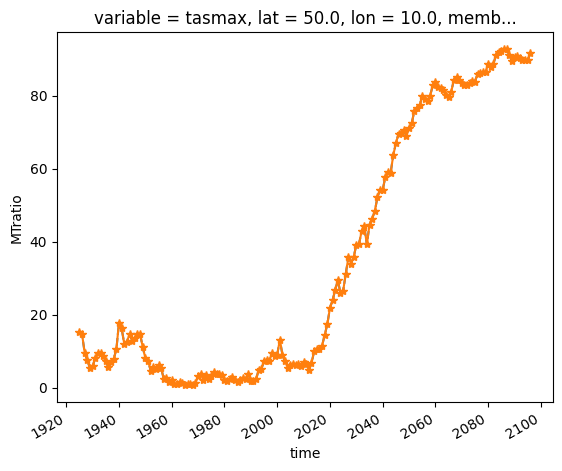

In [31]:
# for i in range(len(test_return.concat_dim)):
test_return.isel(variable=0, region=0, concat_dim=0).MTratio.plot(linestyle='dashed')
test_return.isel(variable=0, region=0, concat_dim=1).MTratio.plot(marker='*')

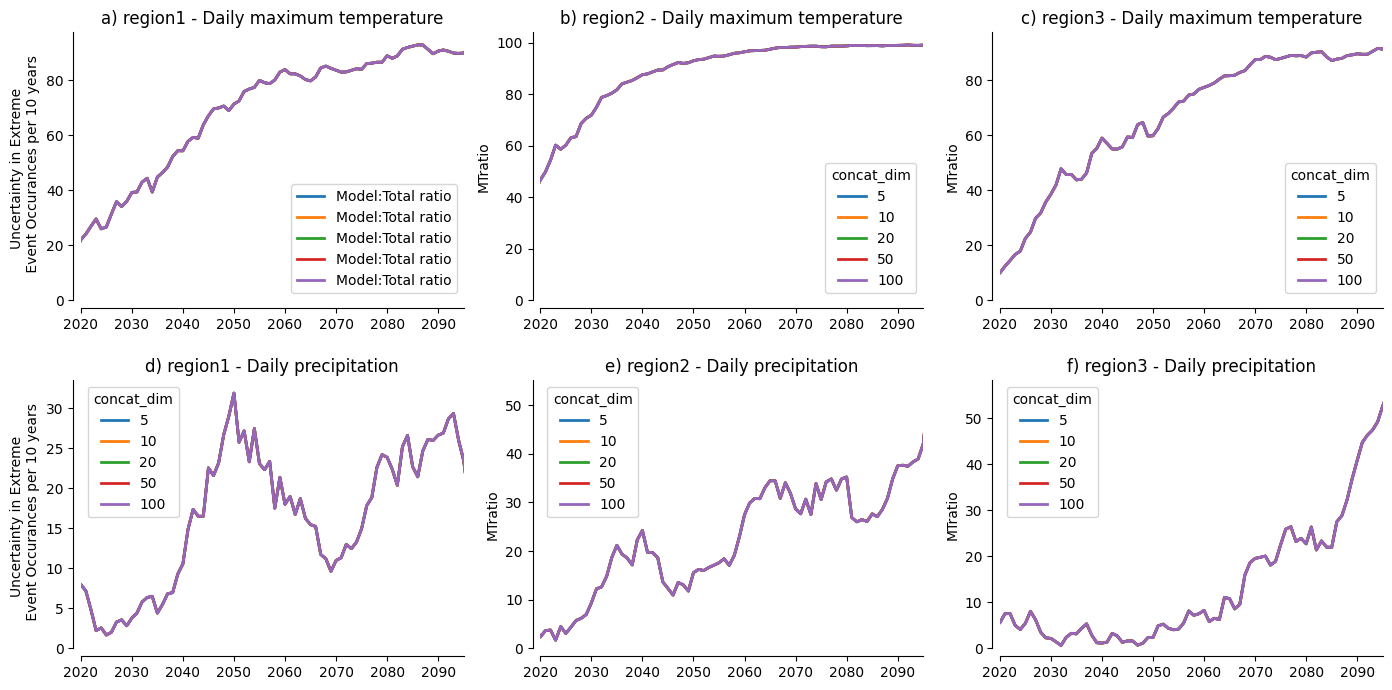

In [50]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        test_return.sel(variable=v, region=r).MTratio.plot(hue='concat_dim',ax=ax, lw=2,label='Model:Total ratio')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per 10 years')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

## Sensitivity plots for paper

#### Get Data 

In [66]:
# setting 
# variable = 'tas'
# variable = 'tasmax'
# variable = 'pr'
models = ['MIROC6', 'MPI-ESM1-2-LR', 'EC-Earth3','cesm_lens']

In [67]:
regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [68]:
# USwest = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
#                                lat=37.7, lon=237.6, 
#                                bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [69]:
seattle_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=47.6, lon=237.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [70]:
montreal_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=45.5, lon=286.2, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [71]:
lagos_pr = MultiModelLargeEnsemble(models=models, variable='pr', granularity='day', 
                               lat=6.5, lon=3.4, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [72]:
seattle_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=47.6, lon=237.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [73]:
montreal_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=45.5, lon=286.2, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [74]:
lagos_tas = MultiModelLargeEnsemble(models=models, variable='tas', granularity='day', 
                               lat=6.5, lon=3.4, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

#### Test_return

In [80]:
test_return_pr = sensitivity_allregions(parameter='return_period',
                                     regions=[seattle_pr,montreal_pr,lagos_pr],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


34.27495574951172


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


34.27891540527344


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


34.280296325683594


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


34.27711868286133


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


34.278724670410156


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


34.27613067626953


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


34.279239654541016


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


34.28200149536133


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


34.27277374267578


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


34.278228759765625


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


34.27690124511719


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


34.27772521972656


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


34.276145935058594


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


34.277957916259766


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


34.27665328979492


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


34.27824020385742


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


34.273921966552734


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


34.27748107910156


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


34.27812957763672


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


34.27960968017578


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


34.28016662597656


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


34.27967834472656


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


34.28264617919922


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


34.280887603759766


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


34.27372360229492


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


34.27400207519531


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


34.27923583984375


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


34.276649475097656


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


34.27465057373047


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


34.28233337402344


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


34.27809524536133


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


34.27964401245117


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


34.27603530883789


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


34.27568435668945


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


34.27497863769531


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


34.27484893798828


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


34.274627685546875


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


34.27536392211914


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


34.27676010131836


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


34.27482223510742


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


34.27962112426758


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


34.27711868286133


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


34.2720832824707


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


34.27630615234375


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


34.17832946777344


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


34.175071716308594


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


34.17711639404297


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


34.173492431640625


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


34.17191696166992


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


34.176753997802734


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


34.17116165161133


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


34.17567443847656


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


34.172454833984375


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


34.175819396972656


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


34.17652130126953


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


34.1742057800293


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


34.17860794067383


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


34.1747932434082


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


34.17262649536133


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

34.1694221496582


In [81]:
test_return_tas = sensitivity_allregions(parameter='return_period',
                                     regions=[seattle_tas,montreal_tas,lagos_tas],
                 x_type='quantile_return',
                 load=False,
                 args = {'return_period':[5,10,20,50,100],
                            'coarsen':1,
                            'consec_days':1,
                            'rolling_average':10,
                            'hist_slice':slice('1995','2014')
                            })

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


34.16822814941406


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


34.17124938964844


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


34.16986083984375


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


34.16796112060547


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


34.176513671875


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


34.17402648925781


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


34.17189025878906


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


34.177398681640625


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


34.1790771484375


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


34.17533874511719


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


34.17557907104492


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


34.17195510864258


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


34.17202377319336


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


34.17672348022461


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


34.17515563964844


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


34.17005920410156


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


34.17578887939453


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


34.17213439941406


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


34.174415588378906


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


34.29336166381836


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


34.36425018310547


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


34.36606216430664


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


34.40259552001953


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


34.42106246948242


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


34.418697357177734


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


34.4246711730957


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


34.42262649536133


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


34.42894744873047


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


34.4211540222168


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


34.426509857177734


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


34.42426300048828


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


34.4232177734375


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


34.42726135253906


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


34.430442810058594


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


34.426300048828125


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


34.42620086669922


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


34.427772521972656


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


34.424835205078125


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


34.424896240234375


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


34.424415588378906


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


34.42613983154297


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


34.424888610839844


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


34.41991424560547


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


34.426475524902344


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


34.42192840576172


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


34.42900848388672


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


34.41884994506836


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


34.45006561279297


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


34.436588287353516


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


34.45035171508789


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


34.57936477661133


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


34.42649459838867


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


34.42914962768555


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


34.420597076416016


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


34.42637252807617


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


34.4256706237793


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


34.42707443237305


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


34.4276237487793


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


34.43129348754883


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

34.425025939941406


In [82]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_return = xr.concat([test_return_tas,test_return_pr], dim=variable_dim)

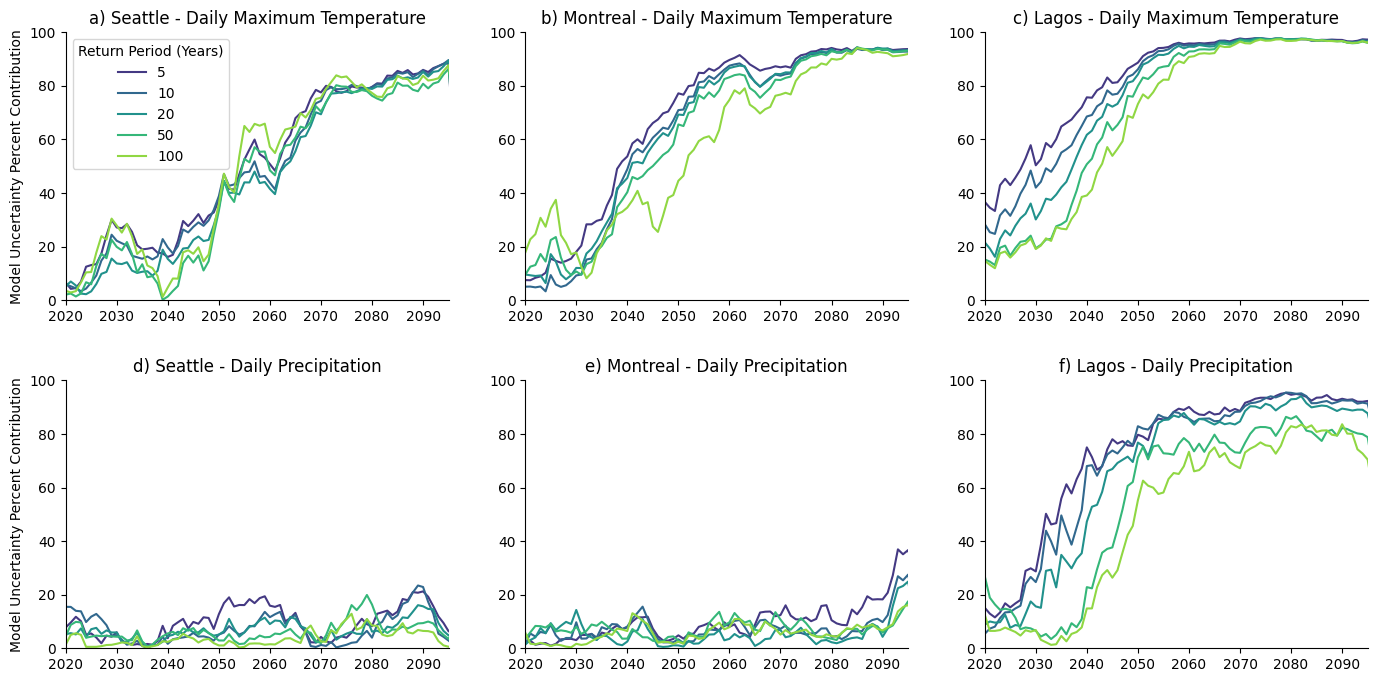

In [83]:
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels,title='Return Period (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testreturn.png', dpi=200)

#### Hist slice

In [93]:
test_histslice_pr = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_pr,australia_pr,tropics_pr],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.495567321777344


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


43.499839782714844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.494895935058594


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


43.49604797363281


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.49299621582031


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.499534606933594


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.496055603027344


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


43.48876190185547


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


43.496498107910156


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.4984130859375


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.497711181640625


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49108123779297


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


43.48831558227539


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.490882873535156


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.490867614746094


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.506771087646484


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.500240325927734


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


43.502193450927734


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.498050689697266


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


43.49942398071289


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


43.50468063354492


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.50578689575195


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


43.50534439086914


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


43.50114059448242


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


43.5012092590332


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.507625579833984


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.50717544555664


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


43.5085334777832


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.50553512573242


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


43.503292083740234


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.50957107543945


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.50802230834961


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.51580810546875


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.507232666015625


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


43.50659942626953


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


43.50447082519531


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


43.486602783203125


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.490447998046875


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49354553222656


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


43.49663543701172


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.49140167236328


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


43.49591827392578


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


43.49089050292969


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


43.48646926879883


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


43.4940299987793


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


43.49288558959961


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49153518676758


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


43.4868278503418


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498291015625


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.489845275878906


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


43.48564910888672


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


43.492889404296875


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.486656188964844


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


43.4886474609375


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


43.48809814453125


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.492591857910156


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


43.48925018310547


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


43.49895477294922


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


43.485870361328125


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


43.4912109375


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


43.48916244506836


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


43.48597717285156


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


43.48873519897461


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


43.49506378173828


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


43.49443054199219


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


43.49371337890625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.49542999267578


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


43.498008728027344


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


43.495384216308594


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


43.494873046875


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


43.49029541015625


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


43.5010986328125


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


43.494140625


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


43.49419403076172


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

43.49623107910156


In [94]:
test_histslice_tas = sensitivity_allregions(parameter='hist_slice',
                                        regions=[europe_tas,australia_tas,tropics_tas],
                                        x_type = 'quantile_return',
                                        load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1980','2000'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)]
                                               }
                                       )

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.487613677978516


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


43.492008209228516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.49648666381836


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


43.4976806640625


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


43.49931335449219


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.49424743652344


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.493980407714844


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


43.498870849609375


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


43.48797607421875


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


43.490386962890625


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.49718475341797


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


43.488059997558594


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.49236297607422


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49052429199219


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


43.495689392089844


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.498252868652344


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


43.489295959472656


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


43.494422912597656


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


43.49809265136719


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48759460449219


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


43.48970413208008


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


43.49335479736328


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


43.497310638427734


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49204635620117


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.48992156982422


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


43.490318298339844


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


43.489776611328125


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


43.49394226074219


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.489227294921875


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.493011474609375


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49131774902344


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


43.49070739746094


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


43.48875427246094


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.49186706542969


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


43.489437103271484


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49137496948242


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


43.49692916870117


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.485252380371094


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49052810668945


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


43.49135208129883


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.493831634521484


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49077224731445


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


43.49051284790039


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.4970817565918


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


43.4931526184082


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


43.4910774230957


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


43.49101638793945


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


43.487491607666016


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.48861312866211


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


43.49637222290039


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


43.48923873901367


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.49325180053711


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


43.48691177368164


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


43.487789154052734


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


43.500701904296875


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


43.49015426635742


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


43.4957389831543


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


43.49274826049805


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


43.49241256713867


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


43.487613677978516


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


43.494991302490234


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.4929313659668


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


43.49374771118164


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


43.49514389038086


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


43.489749908447266


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


43.49013137817383


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


43.495723724365234


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


43.49361038208008


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


43.49717330932617


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


43.496891021728516


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


43.49795150756836


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


43.49160385131836


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

43.49677276611328


In [95]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_histslice = xr.concat([test_histslice_tas,test_histslice_pr], dim=variable_dim)

In [97]:
test_histslice

<xarray.Dataset>
Dimensions:     (variable: 2, time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * variable    (variable) <U6 'tasmax' 'pr'
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (variable, region, model) float64 301.7 298.2 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) object slice('1980', '2000', None) ... slice('19...
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (variable, region, concat_dim, time) float64 0.08736 ... nan
    I_LE        (variable, region, concat_dim, model, time) float64 4.002 ......
    Ibar_LE     (variable, region, concat_dim, time) float64 4.941 4.962 ... nan
    T_LE        (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    FIT         (variable, region, concat_dim, time, model) float64 2.544 ......
    M_FIT       (variable, region, concat_dim, time) float64 24.63 ... 4.248
    I_FIT       (variable, region, concat_dim, model) float64 171.1 ... 0.842
    Ibar_FIT    (variable, region, concat_dim) float64 283.5 181.0 ... 0.6926
    T_FIT       (variable, region, concat_dim, time) float64 3.216 3.198 ... nan
    MTratio     (variable, region, concat_dim, time) float64 1.737 1.582 ... nan

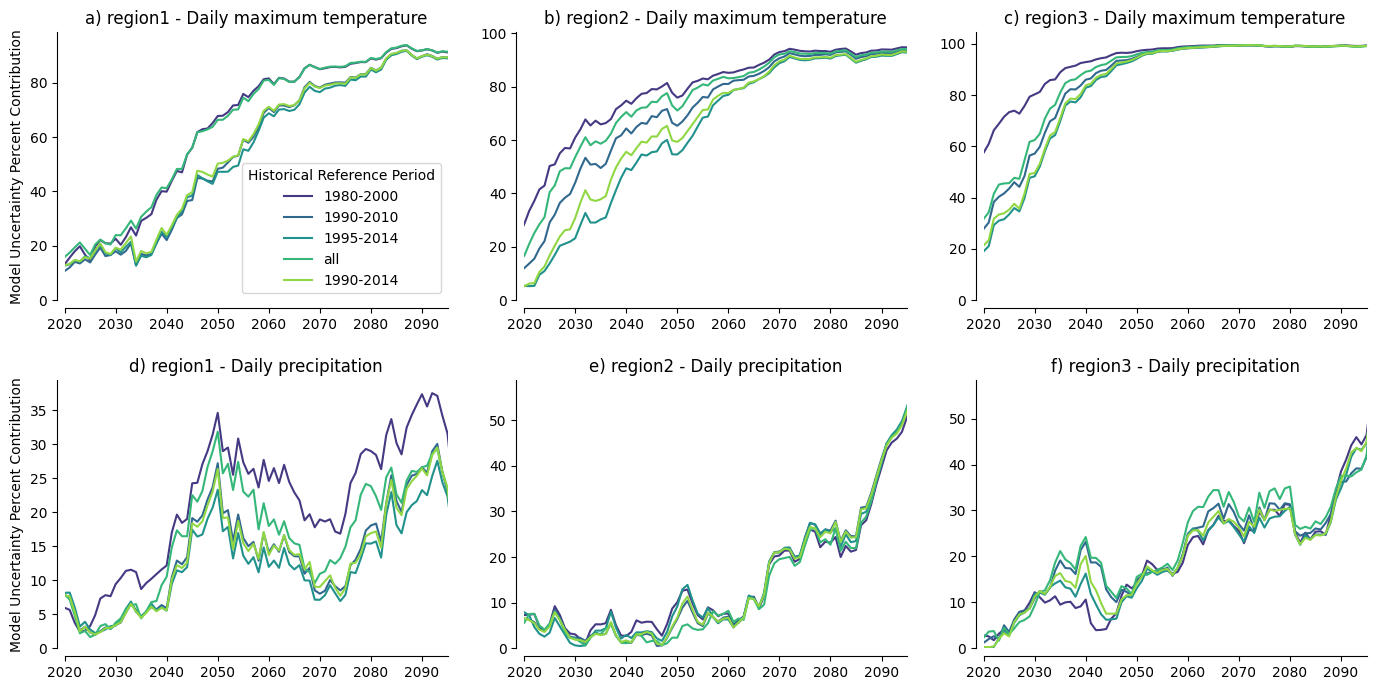

In [102]:
colors = sns.color_palette("viridis", len(test_histslice.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_histslice['variable'].values):
    for ir, r in enumerate(test_histslice.region.values):
        ax = axs[iv, ir]
        for im in range(len(test_histslice.concat_dim.values)):
            ax.plot(test_histslice.sel(variable=v,region=r).isel(concat_dim=im).time,test_histslice.sel(variable=v,region=r).isel(concat_dim=im).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
axs[0, 0].legend(labels=labels,title='Historical Reference Period')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testhistslice.png', dpi=200)

#### Test coarsen

In [84]:
test_coarsen_tas = sensitivity_allregions(parameter='coarsen',
                                          regions=[seattle_tas,montreal_tas,lagos_tas],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


34.43132781982422


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


34.4270133972168


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


34.43003463745117


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


34.430110931396484


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


34.428627014160156


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


34.42415237426758


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


34.436100006103516


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


34.437129974365234


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


34.4255485534668


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


34.42927932739258


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


34.42947769165039


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


34.430057525634766


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


34.428951263427734


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


34.43326187133789


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


34.426856994628906


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


34.454471588134766


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


34.442989349365234


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


34.45975112915039


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


34.547935485839844


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


34.57628631591797


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


34.63455581665039


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


34.65591812133789


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


34.71436309814453


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


34.740169525146484


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


34.799869537353516


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


34.798519134521484


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


34.861820220947266


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


34.90240478515625


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


34.96051788330078


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


34.97367858886719


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


35.0195198059082


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


35.04875564575195


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


35.06875228881836


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


35.080135345458984


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.14638137817383


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


35.19383239746094


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


35.23977279663086


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


35.23621368408203


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

35.245201110839844



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


35.24152374267578


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.2410888671875


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


35.247161865234375


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.248687744140625


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


35.24718475341797


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


35.24205017089844


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


35.241065979003906


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.2418212890625


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

35.24730682373047


In [85]:
test_coarsen_pr = sensitivity_allregions(parameter='coarsen',
                                          regions=[seattle_pr,montreal_pr,lagos_pr],
                                    x_type = 'quantile_return',
                                    load=False,
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'consec_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014')
                                            
                                           })

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


35.241905212402344


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


35.244346618652344


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


35.2437858581543


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.24931716918945


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.247135162353516


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


35.24223709106445


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


35.242523193359375


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


35.24204635620117


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


35.240665435791016


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


35.354209899902344


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


35.241859436035156


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


35.2372932434082


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.243865966796875


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


35.246490478515625


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.243614196777344


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


35.241233825683594


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


35.246856689453125


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


35.24361801147461


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


35.246124267578125


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


35.24496078491211


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


35.24995803833008


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


35.2421760559082


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


35.24345016479492


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


35.2408447265625


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.2415771484375


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


35.246429443359375


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


35.24668884277344


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


35.245426177978516


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


35.2414665222168


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


35.23875045776367


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


35.24324417114258


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


35.2424430847168


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


35.24312210083008


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


35.237247467041016


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


35.25083541870117


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


35.24970626831055


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


35.24185562133789


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


35.243350982666016


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.239871978759766


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


35.23947525024414


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.24074935913086


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


35.24302291870117


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


35.239864349365234


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


35.246646881103516


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


35.24498748779297


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


35.23973846435547


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


35.237388610839844


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

35.24560546875


In [86]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_coarsen = xr.concat([test_coarsen_tas,test_coarsen_pr], dim=variable_dim)

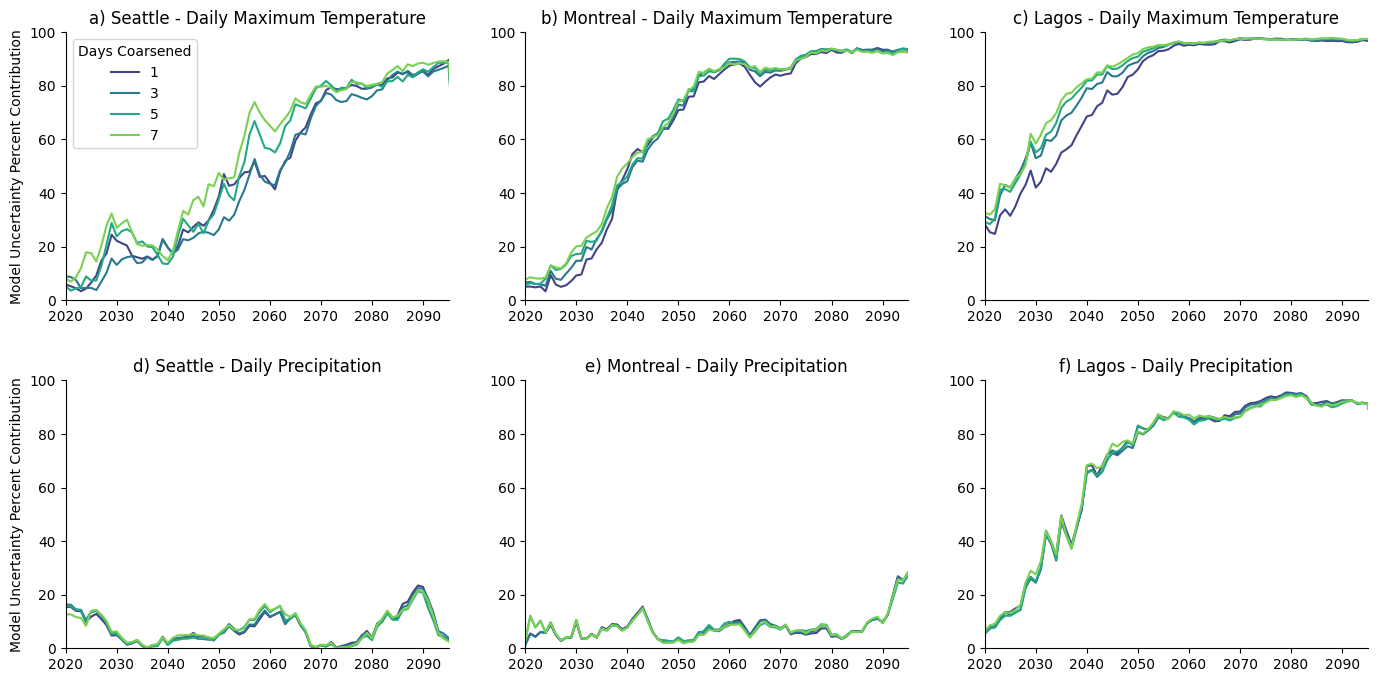

In [87]:
colors = sns.color_palette("viridis", len(test_coarsen.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_coarsen['variable'].values):
    for ir, r in enumerate(test_coarsen.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_coarsen.concat_dim.values):
            ax.plot(test_coarsen.sel(variable=v,region=r,concat_dim=m).time,test_coarsen.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Days Coarsened')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testcoarsen.png', dpi=200)

#### Test consecutive days

In [88]:
test_consec_tas = sensitivity_allregions(parameter='consec_days',
                                         regions=[seattle_tas,montreal_tas,lagos_tas],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.24128341674805


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


35.24335861206055


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


35.242122650146484


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


35.24425506591797


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


35.242645263671875


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


35.2457275390625


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


35.24364471435547


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.24054718017578


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


35.24590301513672


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


35.25055694580078


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


35.246681213378906


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


35.244571685791016


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


35.24210739135742


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


35.245967864990234


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


35.240333557128906


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


35.24663543701172


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.247901916503906


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


35.242713928222656


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


35.239219665527344


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


35.24302673339844


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


35.241615295410156


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

35.24298858642578



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


35.24540328979492


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


35.242149353027344


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


35.24228286743164


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


35.242984771728516


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


35.2387580871582


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


35.25092697143555


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


35.241512298583984


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


35.24467849731445


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


35.24092483520508


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


35.240291595458984


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


35.255157470703125


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


35.24628448486328


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


35.24504852294922


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


35.24755096435547


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


35.258941650390625


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


35.25658416748047


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


35.25360870361328


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


35.25608825683594


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


35.37761688232422


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


35.26273727416992


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


35.25508499145508


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


35.25679397583008


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


35.25559616088867


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


35.25532150268555


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


35.256404876708984


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

35.251529693603516


In [89]:
test_consec_pr = sensitivity_allregions(parameter='consec_days',
                                         regions=[seattle_pr,montreal_pr,lagos_pr],
                                     x_type='quantile_return',
                                     load=False,
                       args= {'return_period':10,
                              'coarsen':7,
                              'consec_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014')
                             }
                      )

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.260276794433594


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


35.25609588623047


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


35.25628662109375


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.261497497558594


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


35.259490966796875


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


35.25225830078125


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


35.25206756591797


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


35.25464630126953


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


35.25474166870117


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


35.2583122253418


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


35.25741195678711


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


35.2537727355957


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


35.25838088989258


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


35.26204299926758


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


35.25495529174805


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


35.24979019165039


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.25458908081055


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


35.26017379760742


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


35.25895309448242


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.25483322143555


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


35.25576400756836


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


35.25300979614258


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


35.252620697021484


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


35.253414154052734


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


35.25490951538086


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


35.25355911254883


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


35.2573127746582


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


35.2575569152832


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


35.25360107421875


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


35.260467529296875


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


35.254478454589844


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


35.256317138671875


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


35.253143310546875


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


35.2548828125


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


35.2509880065918


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


35.25349807739258


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.25931167602539


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


35.26130294799805


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


35.25665283203125


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.25774383544922


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


35.25600814819336


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


35.25711441040039


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


35.267337799072266


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.274776458740234


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


35.287967681884766


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


35.3116569519043


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


35.45172882080078


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

35.046268463134766


In [90]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_consec = xr.concat([test_consec_tas,test_consec_pr], dim=variable_dim)

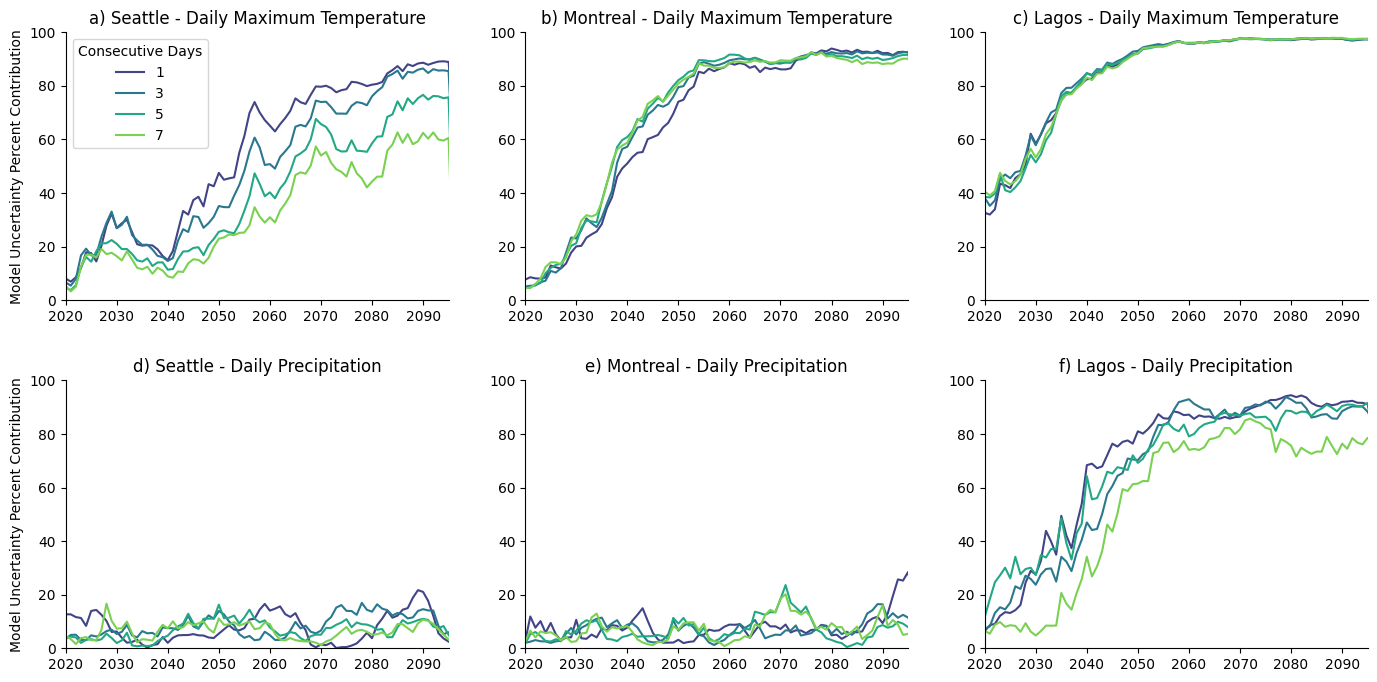

In [91]:
colors = sns.color_palette("viridis", len(test_consec.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_consec['variable'].values):
    for ir, r in enumerate(test_consec.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_consec.concat_dim.values):
            ax.plot(test_consec.sel(variable=v,region=r,concat_dim=m).time,test_consec.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','3','5','7']
axs[0, 0].legend(labels=labels,title='Consecutive Days')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')

for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testconsec.png', dpi=200)

#### test rolling average

In [92]:
test_rolling_tas = sensitivity_allregions(parameter='rolling_average',
                                          regions=[seattle_tas,montreal_tas,lagos_tas],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )

100%|██████████| 1/1 [00:04<00:00,  5.00s/it]


35.101280212402344


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


35.10314178466797


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


35.09419250488281


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


35.10102844238281


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


35.093894958496094


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


35.09466552734375


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


35.10731887817383


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


35.095733642578125


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.10289764404297


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


35.09746551513672


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


35.09529113769531


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


35.09751892089844


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


35.09886932373047


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


35.10179901123047


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.10115051269531


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


35.10292053222656


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


35.10322570800781


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


35.10618591308594


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


35.1025390625


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

35.197994232177734



100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


35.1042594909668


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


35.10648727416992


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


35.10459518432617


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


35.108394622802734


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


35.103092193603516


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


35.107913970947266


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


35.10491943359375


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


35.10778045654297


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


35.1031494140625


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


35.1007080078125


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


35.099830627441406


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


35.09680938720703


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


35.100738525390625


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


35.105316162109375


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


35.103389739990234


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


35.094112396240234


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


35.10005569458008


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


35.09554672241211


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


35.09650421142578


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


35.098419189453125


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.10010528564453


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


35.09827423095703


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


35.10038757324219


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


35.104400634765625


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


35.09428405761719


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


35.10161590576172


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


35.106956481933594


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


35.100746154785156


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


35.09956359863281


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


35.09979248046875


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


35.10181427001953


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


35.104583740234375


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


35.102928161621094


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

35.10228729248047



100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


35.0975341796875


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


35.095909118652344


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


35.10100555419922


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


35.10186767578125


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


35.09881591796875


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

35.10297393798828


In [93]:
test_rolling_pr = sensitivity_allregions(parameter='rolling_average',
                                          regions=[seattle_pr,montreal_pr,lagos_pr],
                                       x_type='quantile_return',
                                     load=False,
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'consec_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014')
                                               }
                                     )

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


35.09893035888672


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


35.097023010253906


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


35.09935760498047


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


35.10152816772461


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


35.1037483215332


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


35.10152053833008


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


35.102108001708984


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


35.10404586791992


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


35.10561752319336


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


35.10031509399414


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.10329055786133


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


35.10081100463867


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


35.10586166381836


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


35.10313034057617


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


35.10065841674805


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


35.09652328491211


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


35.10616683959961


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


35.1024284362793


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


35.098636627197266


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


35.09847640991211


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


35.09440231323242


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


35.09357833862305


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


35.09894943237305


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


35.10280227661133


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


35.100486755371094


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


35.101112365722656


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


35.104644775390625


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


35.106807708740234


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


35.09910202026367


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


35.10691452026367


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


35.10188674926758


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


35.10476303100586


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.102291107177734


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


35.10173416137695


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


35.09712600708008


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


35.09791946411133


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


35.09919357299805


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


35.10478591918945


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


35.10123062133789


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


35.10049819946289


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


35.098941802978516


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


35.10281753540039


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


35.099727630615234


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


35.09630584716797


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


35.09800720214844


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


35.10054016113281


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


35.09590148925781


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


35.097618103027344


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


35.101783752441406


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


35.10170364379883


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


35.096988677978516


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


35.10518264770508


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


35.09535598754883


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


35.1055793762207


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


35.101924896240234


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


35.10000228881836


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


35.102237701416016


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


35.10633850097656


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


35.123870849609375


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

35.124053955078125


In [94]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')
    
test_rolling = xr.concat([test_rolling_tas,test_rolling_pr], dim=variable_dim)

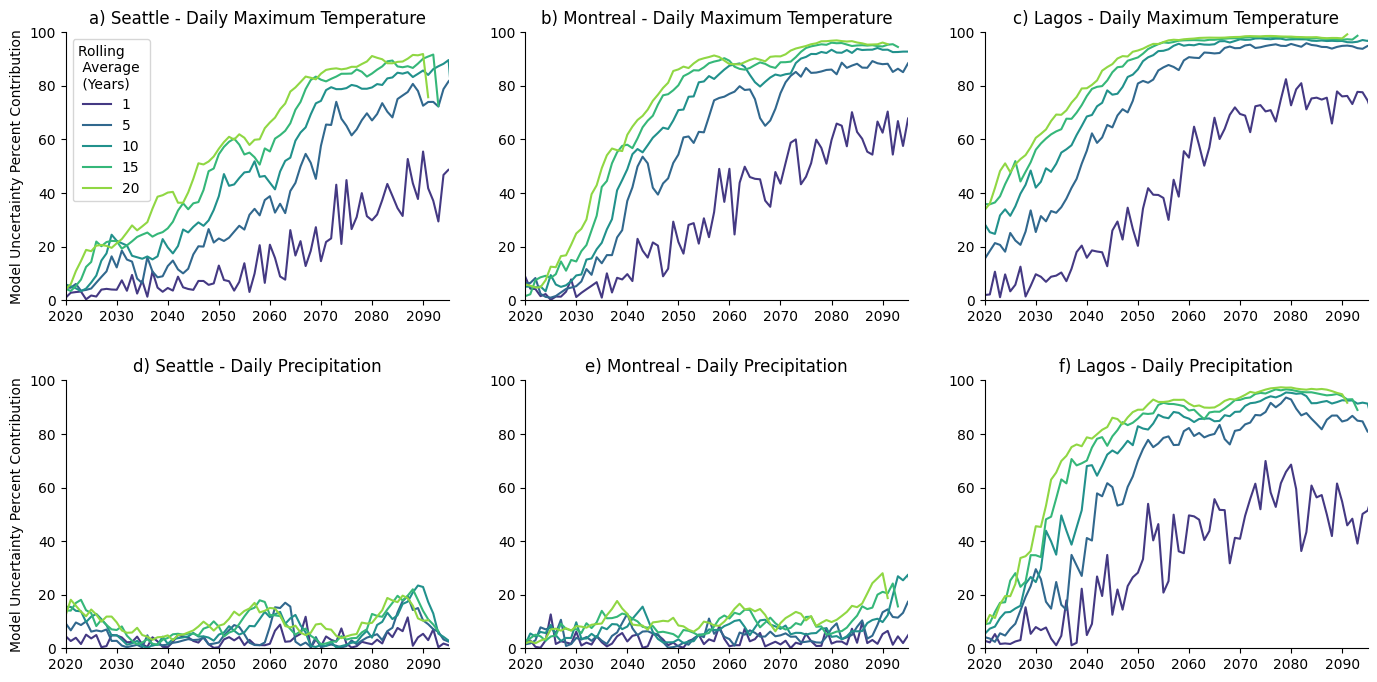

In [95]:
colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_rolling['variable'].values):
    for ir, r in enumerate(test_rolling.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_rolling.concat_dim.values):
            ax.plot(test_rolling.sel(variable=v,region=r,concat_dim=m).time,test_rolling.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['1','5','10','15','20']
axs[0, 0].legend(labels=labels,title='Rolling \n Average \n (Years)')
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
for ax in axs[0,:]:
    ax.set_ylim(bottom=0,top=100)
for ax in axs[1,:]:
    ax.set_ylim(bottom=0,top=100)
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_testrolling.png', dpi=200)

### Tas vs Tasmax

In [96]:
# load global data 
tasmax_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [97]:
tasmax_mmle.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr_1995_2014')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [98]:
tasmax_mmle.x.load()
tasmax_mmle.compute_LE()
tasmax_mmle.compute_FIT()
internal_tasmax = tasmax_mmle.results
tasmax = tasmax_mmle.x

In [99]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [100]:
tas_mmle.compute_x(x_type='quantile_return', load=True, name='tas_default_quantile_return_10yr_1995_2014')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tas_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [101]:
tas_mmle.x.load()
tas_mmle.compute_LE()
tas_mmle.compute_FIT()
internal_tas = tas_mmle.results
tas = tas_mmle.x

In [102]:
# regions = ['region1', 'region2', 'region3']
# lats = [51, 3.9, -25.2]
# lons = [10.5, 306.9, 133.7]
# region_dim = xr.DataArray(regions, coords={'region': regions})

regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [103]:
x = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tas, tasmax]])

In [104]:
x = x.to_array()

In [105]:
variable_dim = xr.DataArray(['tas', 'tasmax'], coords={'variable': ['tas', 'tasmax']}, name='variable')

In [106]:
internal = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tas, internal_tasmax]], dim=variable_dim)

In [107]:
internal['MTratio'] = (internal.M_LE/(internal.M_LE+internal.Ibar_LE))*100

In [108]:
internal

<xarray.Dataset>
Dimensions:    (variable: 2, time: 106, region: 3, model: 4)
Coordinates:
  * variable   (variable) <U6 'tas' 'tasmax'
  * time       (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat        (region) float64 47.5 45.0 7.5
    lon        (region) float64 237.5 285.0 2.5
  * model      (model) <U13 'MIROC6' 'cesm_lens' 'MPI-ESM1-2-LR' 'EC-Earth3'
    q_values   (variable, model, region) float64 298.9 301.4 ... 308.5 313.9
    quantile   (model) float64 0.9997 0.9997 0.9997 0.9997
    member_id  int64 1
  * region     (region) <U8 'Seattle' 'Montreal' 'Lagos'
Data variables:
    M_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    I_LE       (variable, model, time, region) float64 nan nan nan ... nan nan
    Ibar_LE    (variable, time, region) float64 nan nan nan nan ... nan nan nan
    T_LE       (variable, time, region) float64 nan nan nan nan ... nan nan nan
    FIT        (variable, time, model, region) float64 23.08 -8.16 ... 542.8
    M_FIT      (variable, time, region) float64 50.38 215.6 ... 4.032e+04
    I_FIT      (variable, model, region) float64 46.48 56.1 ... 155.7 221.4
    Ibar_FIT   (variable, region) float64 34.75 114.8 172.0 35.42 164.0 88.17
    T_FIT      (variable, time, region) float64 nan nan nan nan ... nan nan nan
    MTratio    (variable, time, region) float64 nan nan nan nan ... nan nan nan

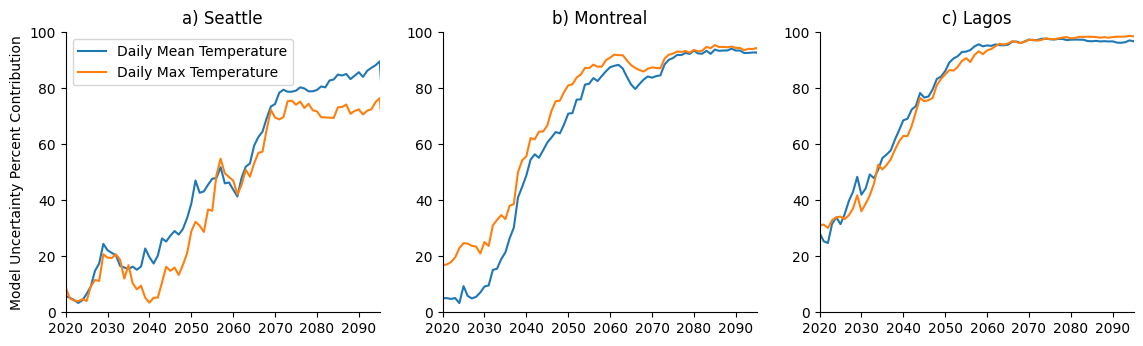

In [109]:
# colors = sns.color_palette("viridis", len(test_rolling.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=1,ncols=3, constrained_layout=True,figsize=(12,4))

axes = [axs[0],axs[1],axs[2]]
regions = ['Seattle','Montreal','Lagos']
count=0
for ax,r in zip(axes,regions):
    ax.plot(internal.sel(variable='tas',region=r).time,internal.sel(variable='tas',region=r).MTratio,label='Daily Mean Temperature')
    ax.plot(internal.sel(variable='tasmax',region=r).time,internal.sel(variable='tasmax',region=r).MTratio,label='Daily Max Temperature')
    
    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    ax.set_ylim(bottom=0,top=100)
    ax.set_title(f'{string.ascii_lowercase[count]}) {r}')
    ax.set_xlabel('')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.spines["bottom"].set_position(("axes", -0.03)) 
    # ax.spines["left"].set_position(("axes", -0.02))
    count += 1
axs[0].legend()
axs[0].set_ylabel('Model Uncertainty Percent Contribution')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.2, top=0.9, wspace=0.20, hspace=0.70)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_tastasmax.png', dpi=200)

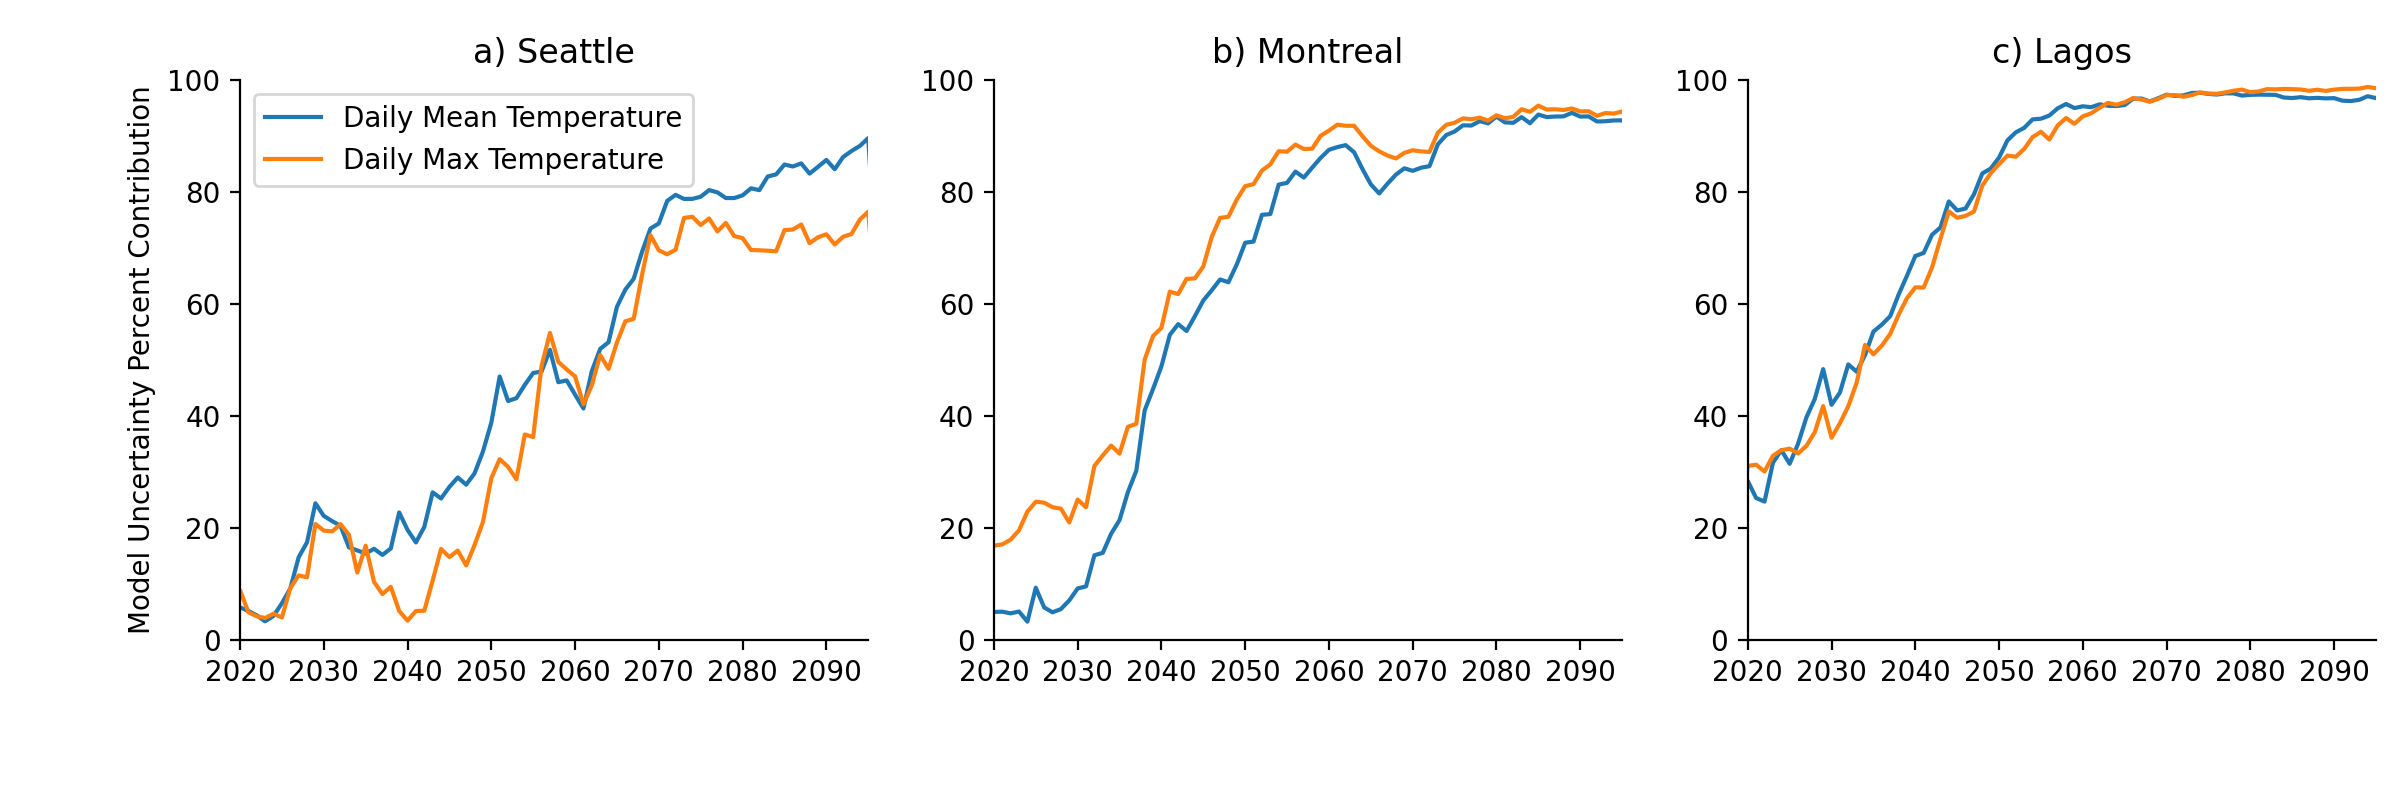

In [110]:
from IPython.display import Image
Image(filename='./plots/sensitivity_tastasmax.png')   # Don't believe what Jupyter shows you!

## Default vs TXx returns vx TXx

### Default

In [111]:
# load global data 
tasmax_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_default.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr_1995_2014')

tasmax_default.x.load()
tasmax_default.compute_LE()
tasmax_default.compute_FIT()
internal_tasmax_default = tasmax_default.results
tasmax_default = tasmax_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [112]:
# load global data 
pr_default = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_default.compute_x(x_type='quantile_return', load=True, name='pr_default_quantile_return_10yr_1995_2014')

pr_default.x.load()
pr_default.compute_LE()
pr_default.compute_FIT()
internal_pr_default = pr_default.results
pr_default = pr_default.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [113]:
regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_default = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_default, pr_default]])

x_default = x_default.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_default = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_default, internal_pr_default]], dim=variable_dim)

internal_default['MTratio'] = (internal_default.M_LE/(internal_default.M_LE+internal_default.Ibar_LE))*100

### TXx Return

In [114]:
# load global data 
tasmax_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='tasmax_default_TXx_quantile_10yr_1995_2014')

tasmax_TXx_return.x.load()
tasmax_TXx_return.compute_LE()
tasmax_TXx_return.compute_FIT()
internal_tasmax_TXx_return = tasmax_TXx_return.results
tasmax_TXx_return = tasmax_TXx_return.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_quantile_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_quantile_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_quantile_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_quantile_10yr_1995_2014/EC-Earth3.zarr


In [115]:
# load global data 
pr_TXx_return = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx_return.compute_x(x_type='TXx_quantile', load=True, name='pr_default_TXx_quantile_10yr_1995_2014')

pr_TXx_return.x.load()
pr_TXx_return.compute_LE()
pr_TXx_return.compute_FIT()
internal_pr_TXx_return = pr_TXx_return.results
pr_TXx_return = pr_TXx_return.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_quantile_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_quantile_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_quantile_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_quantile_10yr_1995_2014/EC-Earth3.zarr


In [116]:
regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx_return = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tasmax_TXx_return, pr_TXx_return]])

x_TXx_return = x_TXx_return.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx_return = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx_return, internal_pr_TXx_return]], dim=variable_dim)

internal_TXx_return['MTratio'] = (internal_TXx_return.M_LE/(internal_TXx_return.M_LE+internal_TXx_return.Ibar_LE))*100

### TXx

In [117]:
# load global data 
tasmax_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

tasmax_TXx.compute_x(x_type='max', load=True, name='tasmax_default_TXx_1995_2014')

tasmax_TXx.x.load()
tasmax_TXx.compute_LE()
tasmax_TXx.compute_FIT()
internal_tasmax_TXx = tasmax_TXx.results
tasmax_TXx = tasmax_TXx.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_TXx_1995_2014/EC-Earth3.zarr


In [118]:
# load global data 
pr_TXx = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

pr_TXx.compute_x(x_type='max', load=True, name='pr_default_TXx_1995_2014')

pr_TXx.x.load()
pr_TXx.compute_LE()
pr_TXx.compute_FIT()
internal_pr_TXx = pr_TXx.results
pr_TXx = pr_TXx.x

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_TXx_1995_2014/EC-Earth3.zarr


In [119]:
regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

x_TXx = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [tasmax_TXx, pr_TXx]])

x_TXx = x_TXx.to_array()

variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

internal_TXx = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tasmax_TXx, internal_pr_TXx]], dim=variable_dim)

internal_TXx['MTratio'] = (internal_TXx.M_LE/(internal_TXx.M_LE+internal_TXx.Ibar_LE))*100

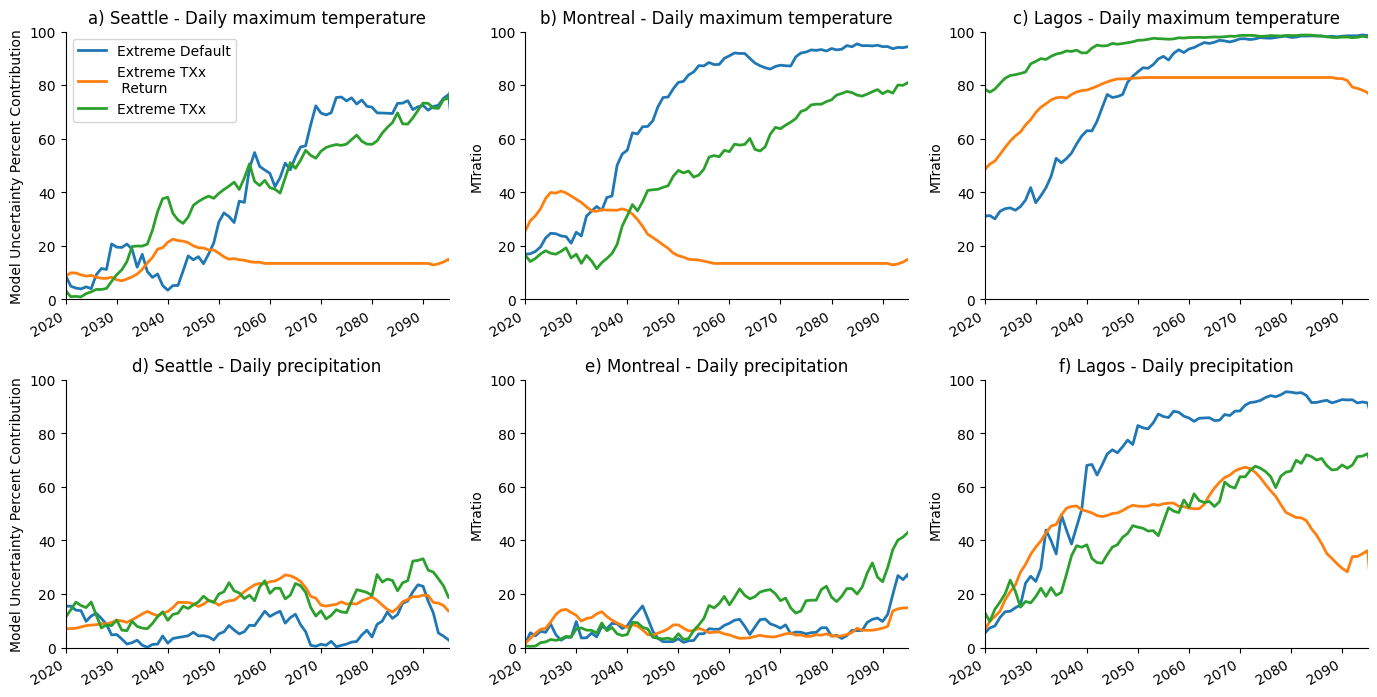

In [125]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal_default['variable'].values):
    for ir, r in enumerate(internal_default.region.values):
        ax = axs[iv, ir]

        internal_default.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme Default')
        internal_TXx_return.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx \n Return')
        internal_TXx.sel(variable=v, region=r).MTratio.plot(ax=ax, lw=2,label='Extreme TXx')
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0,top=100)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/sensitivity_extreme_defs.png', dpi=200)

### plots

In [70]:
test_return

<xarray.Dataset>
Dimensions:     (time: 106, region: 3, concat_dim: 5, model: 5)
Coordinates:
  * time        (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
    lat         (region) float64 50.0 -25.0 5.0
    lon         (region) float64 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9995 0.9995 0.9995 0.9995 0.9995
    q_values    (region, model) float64 0.0005008 0.0003303 ... 0.0003968
    member_id   int64 1
  * concat_dim  (concat_dim) int64 5 10 20 50 100
  * region      (region) <U7 'region1' 'region2' 'region3'
Data variables:
    M_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    I_LE        (region, concat_dim, model, time) float64 nan nan ... nan nan
    Ibar_LE     (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    T_LE        (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    FIT         (region, concat_dim, time, model) float64 -3.01 ... -0.8932
    M_FIT       (region, concat_dim, time) float64 6.309 4.758 ... 0.5905 0.7323
    I_FIT       (region, concat_dim, model) float64 2.954 1.592 ... 0.06174
    Ibar_FIT    (region, concat_dim) float64 1.726 0.8384 ... 0.1543 0.1044
    T_FIT       (region, concat_dim, time) float64 nan nan nan ... nan nan nan
    MTratio     (region, concat_dim, time) float64 nan nan nan ... nan nan nan

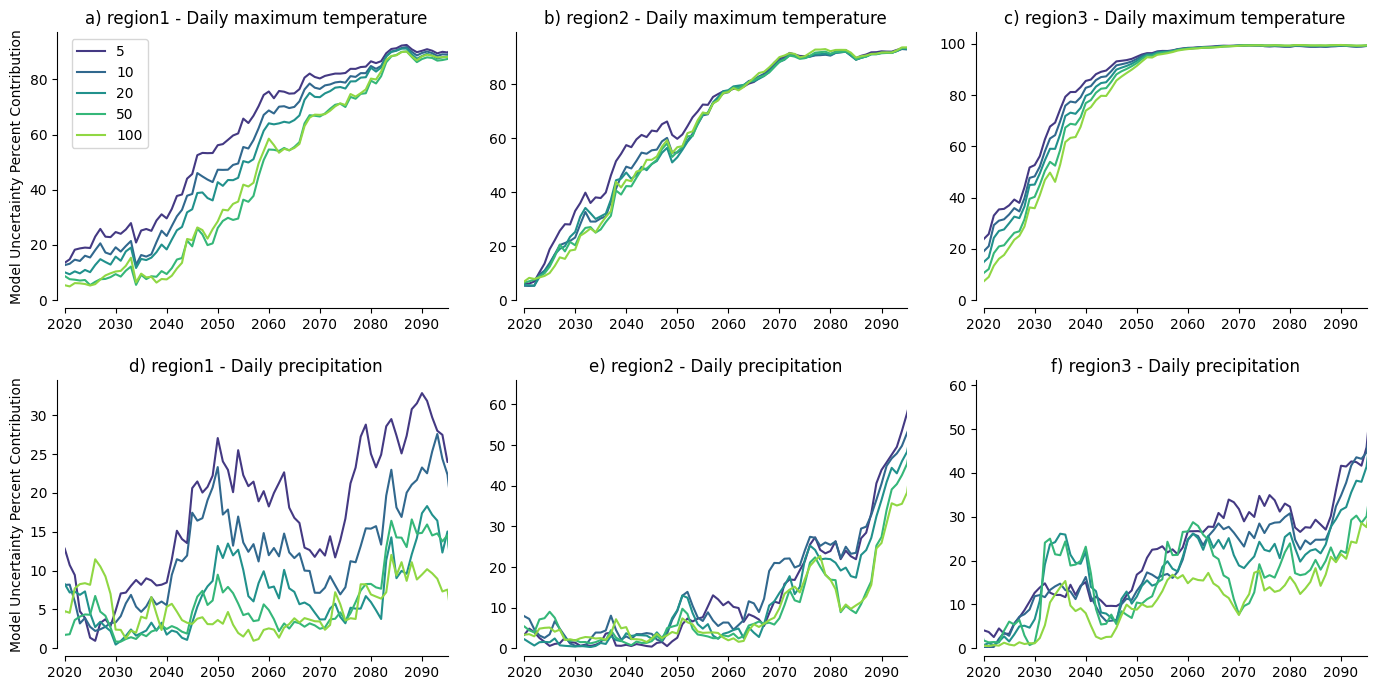

In [91]:
# colors = ['k','b','g','r','orange']
colors = sns.color_palette("viridis", len(test_return.concat_dim))
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(test_return['variable'].values):
    for ir, r in enumerate(test_return.region.values):
        ax = axs[iv, ir]
        for im,m in enumerate(test_return.concat_dim.values):
        # for im, m in enumerate(internal.model.values):
            ax.plot(test_return.sel(variable=v,region=r,concat_dim=m).time,test_return.sel(variable=v,region=r,concat_dim=m).MTratio,c=colors[im])
            # test_return.sel(variable=v, region=r).MTratio.plot(ax=ax,c=colors[im],hue='concat_dim', lw=2,label='Model:Total ratio',add_legend=False)
        
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels=['5','10','20','50','100']
axs[0, 0].legend(labels=labels)
for ax in axs[:, 0]:
    ax.set_ylabel('Model Uncertainty Percent Contribution')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

ValueError: x and y can be no greater than 2D, but have shapes (181,) and (181, 71, 144)

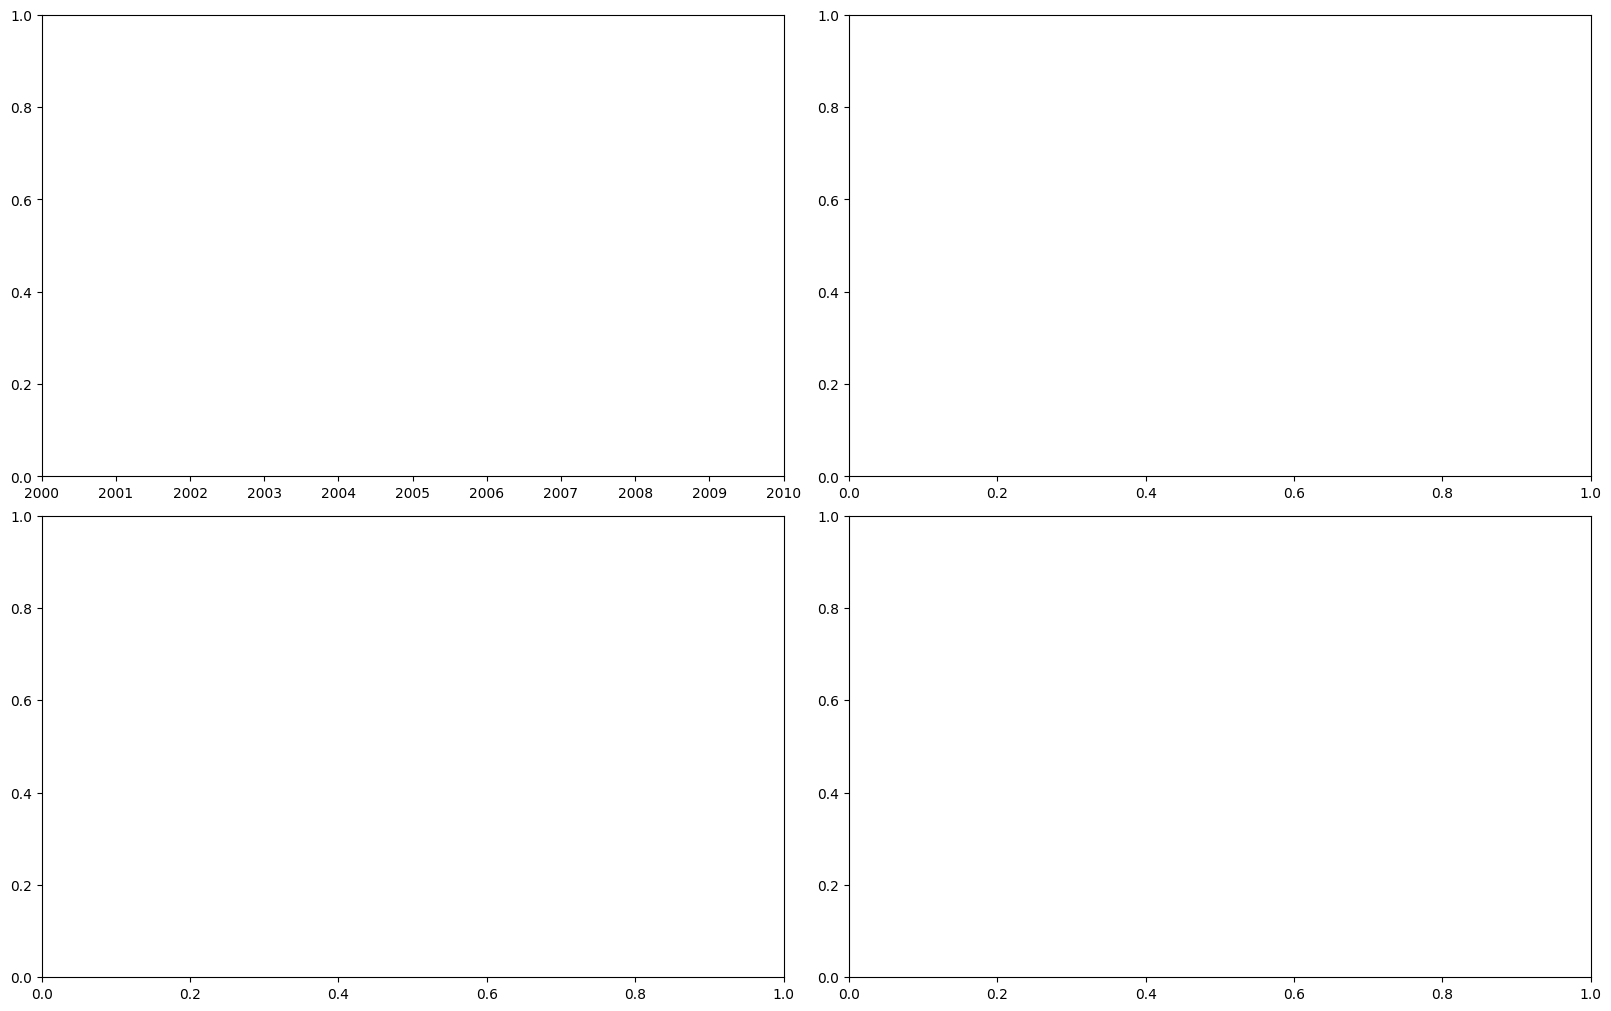

In [40]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

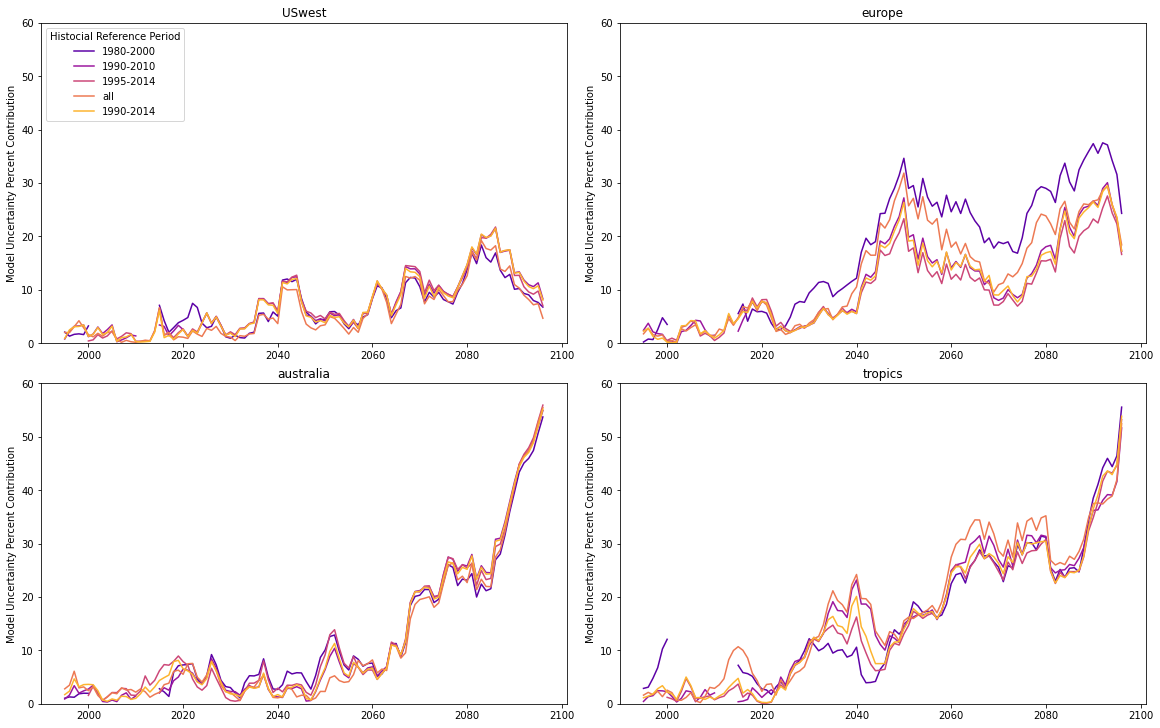

In [44]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,
                 test_histslice.sel(region=r).isel(concat_dim=i).MTratio,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)
labels = ['1980-2000','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

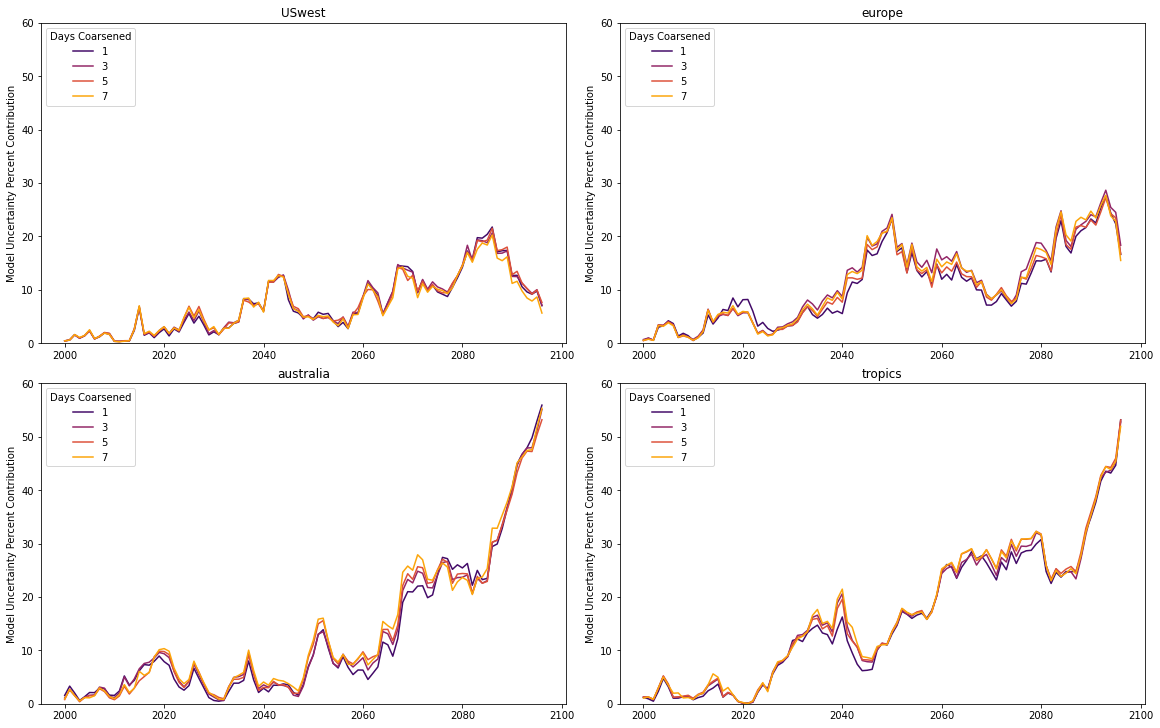

In [46]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

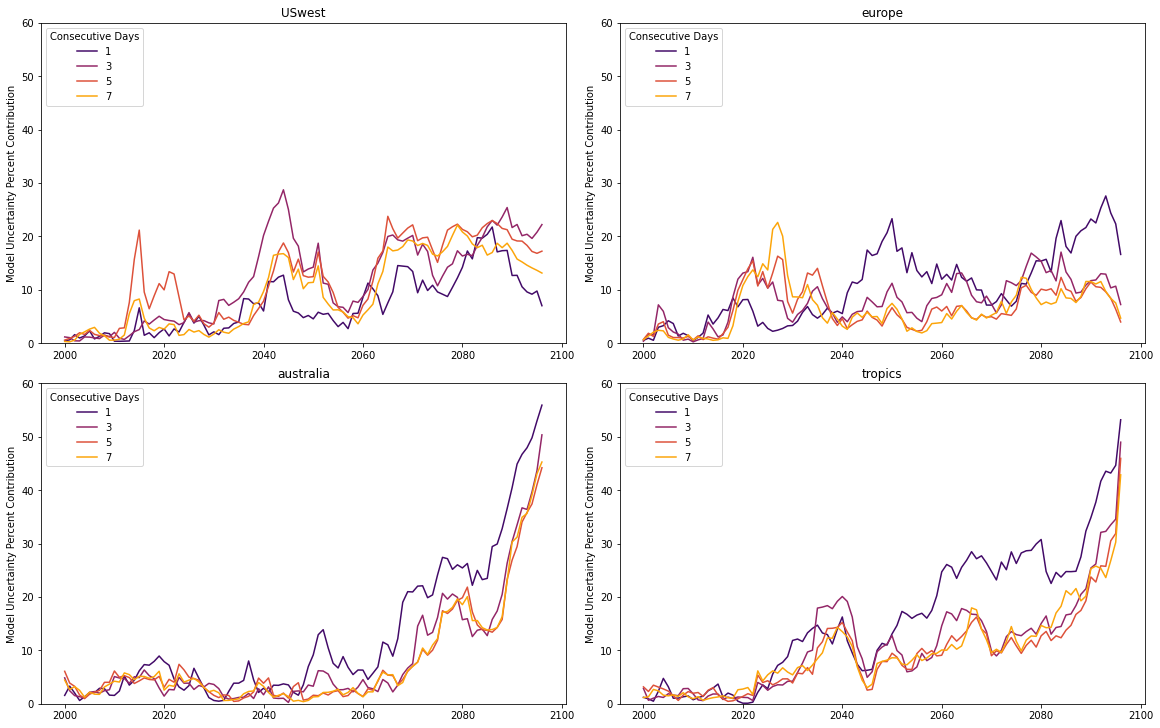

In [49]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,60)

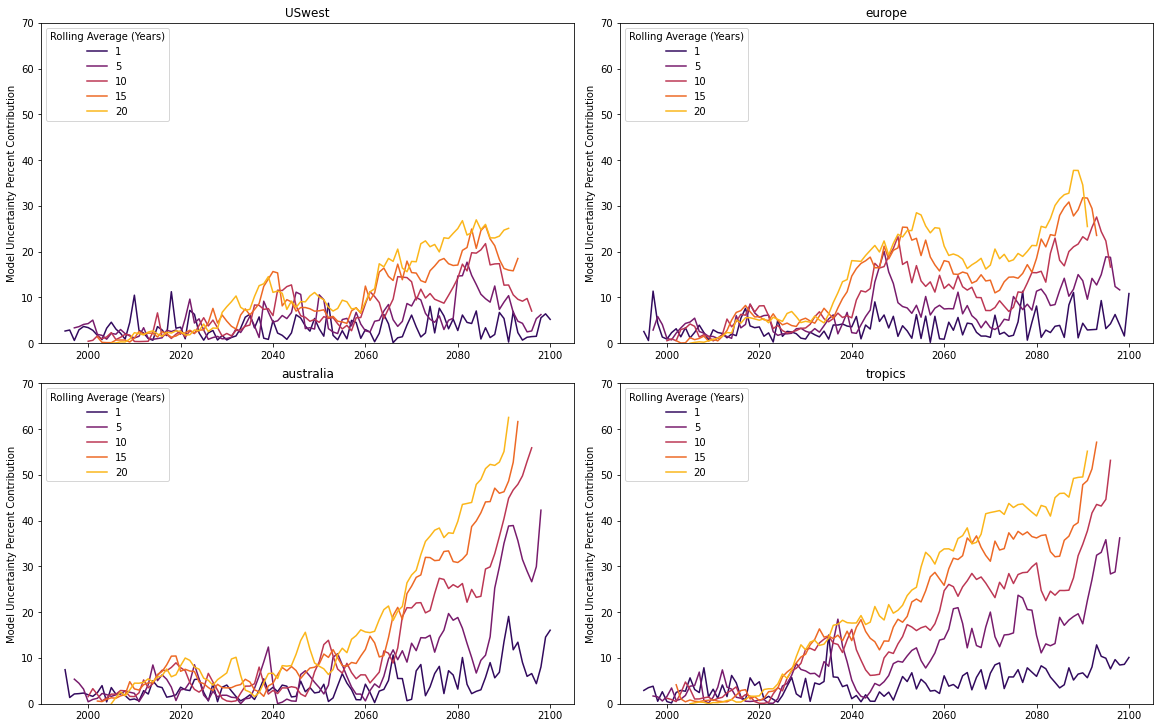

In [53]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).MTratio,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,70)

## Load Datasets - Local code 

In [90]:
# settings 
#for temp
# variable = 'tas'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
variable = 'pr'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [91]:
# USeast = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=41.3, 
#                                  lon=-72.5,bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [92]:
USwest = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [93]:
# iceland = MultiModelLargeEnsemble(models=models,
#                                  variable=variable, granularity='day', lat=65, lon=-19,
#                                  bucket='climateai_data_repository', 
#                                  path='tmp/internal_variability',
#                                  load=True)

In [94]:
europe = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [95]:
australia = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [96]:
tropics = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

### sensitivity testing
using model:internal ratio for testing the various parameters. When ratio > 1, model uncertainty dominates. When ratio < 1, internal variability dominates. 

### Return periods 

In [68]:
test_return = sensitivity_allregions(parameter='return_period',
                                     args = {'return_period':[5,10,20, 50, 100],
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':slice('1995','2014'),
                                             'postprocess':True
                                               })

In [69]:
test_return

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, concat_dim: 5, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           (concat_dim) float64 0.9995 0.9997 0.9999 0.9999 1.0
  * concat_dim         (concat_dim) int64 5 10 20 50 100
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    tas_occurance      (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

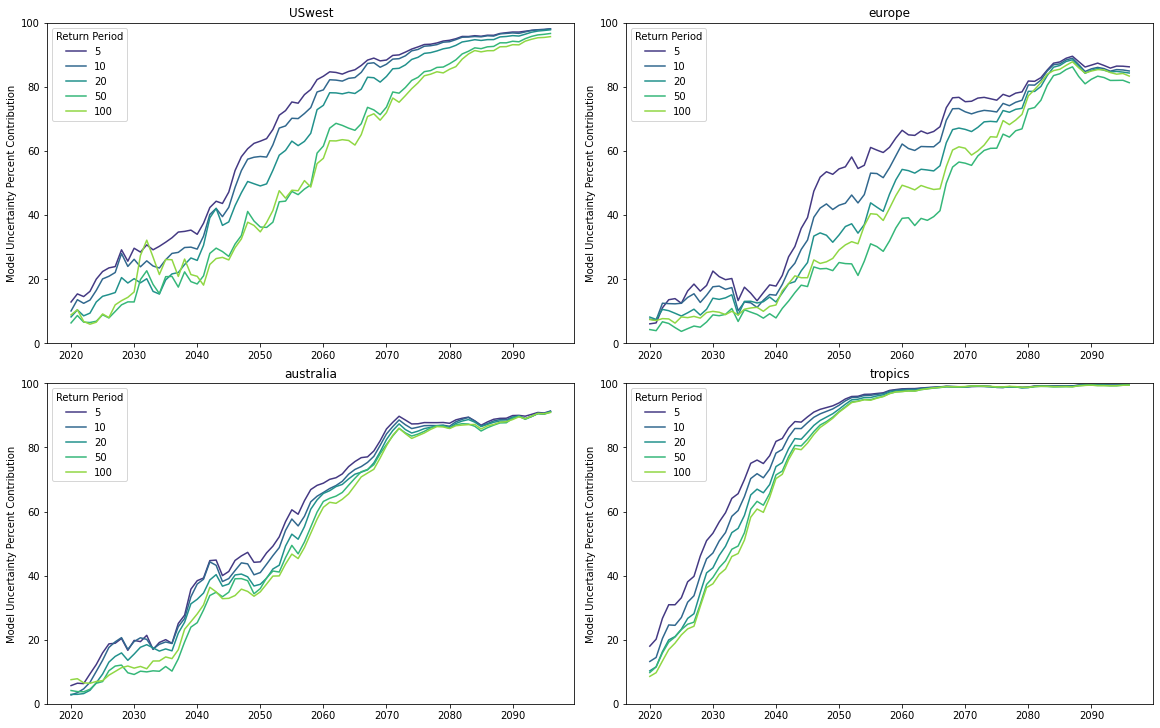

In [71]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

For temp: greater internal variability for larger return periods. US west and Europe have largest spreads. Convergence towards the end of the century for all return periods when model uncertainty dominates. This point is reached much earlier for the tropics. 

### Hist_slice

In [34]:
test_histslice = sensitivity_allregions(parameter='hist_slice',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1920','1940'),slice('1960','1980'),
                                                              slice('1990','2010'),slice('1995','2014'),
                                                              slice(None, None), slice('1990', None)],
                                               'postprocess':False}
                                       )

In [35]:
test_histslice

<xarray.Dataset>
Dimensions:            (time: 86, member: 50, model: 4, concat_dim: 6, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    member_id          (model, member) object 'r16i1p2f1' 'r16i1p1f1' ... nan
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'MPI-ESM1-2-LR'
    quantile           (concat_dim) float64 0.9997 0.9997 ... 0.9997 0.9997
  * concat_dim         (concat_dim) object slice('1920', '1940', None) ... sl...
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    pr_occurance       (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

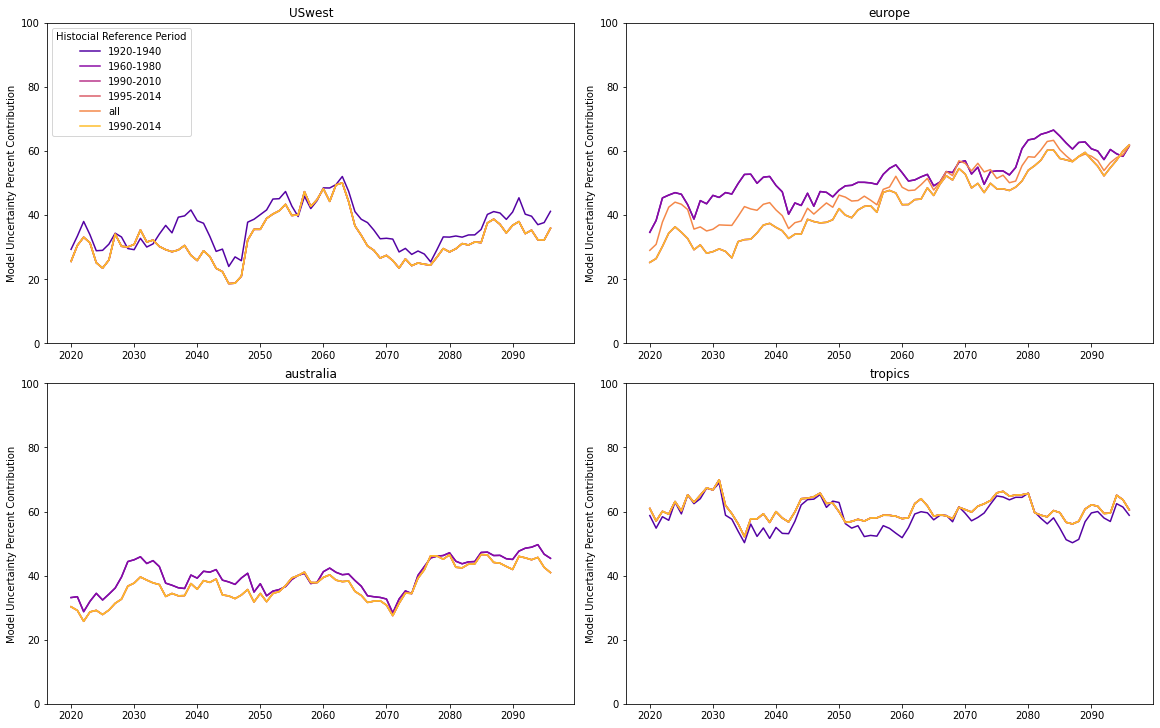

In [56]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("plasma", len(test_histslice.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i in range(len(test_histslice.concat_dim)):
        axe.plot(test_histslice.sel(region=r).isel(concat_dim=i).time,test_histslice.sel(region=r).isel(concat_dim=i).model_le_frac,
                c=colors[i])
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
ax[0,0].legend(labels=labels,loc=2,title='Histocial Reference Period')

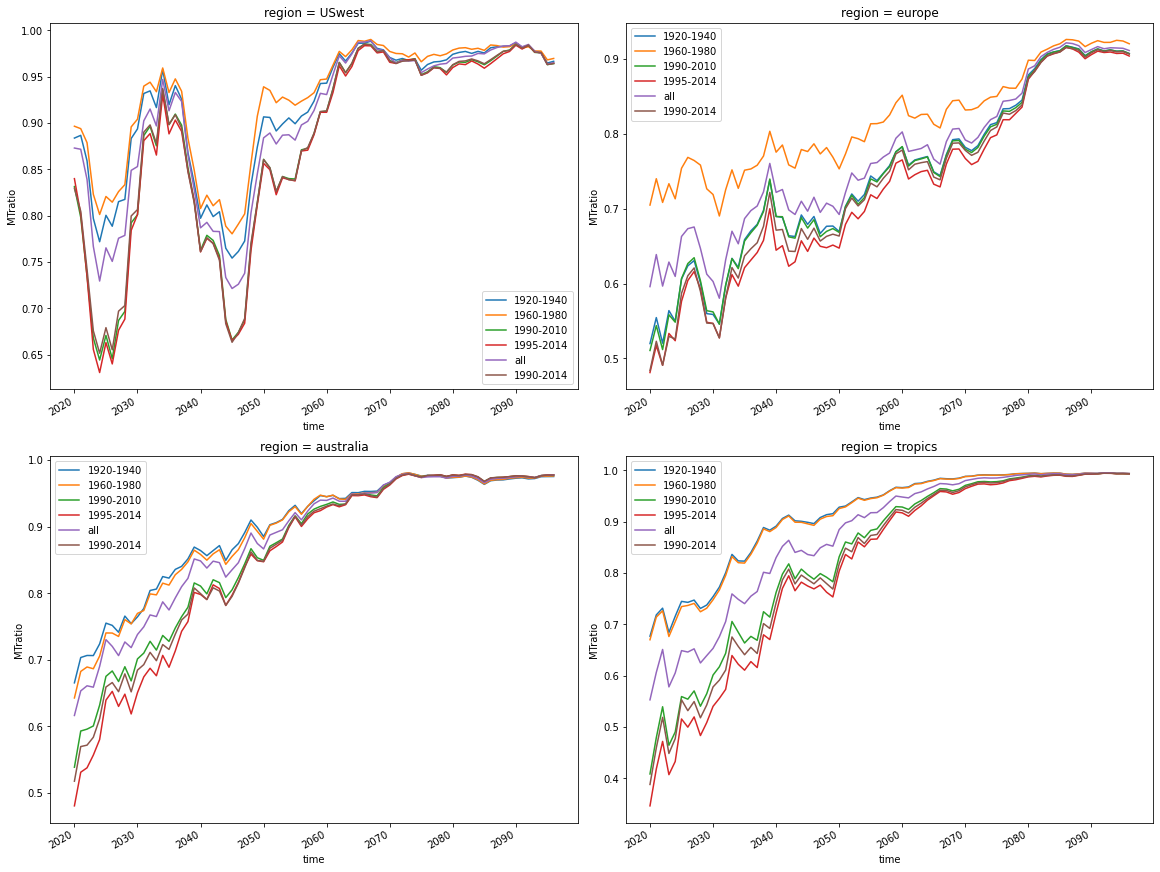

In [34]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_histslice.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe,add_legend=False);
    labels = ['1920-1940','1960-1980','1990-2010','1995-2014','all','1990-2014']
    axe.legend(labels)

### coarsen

In [72]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014'),
                                            'postprocess':True
                                           })

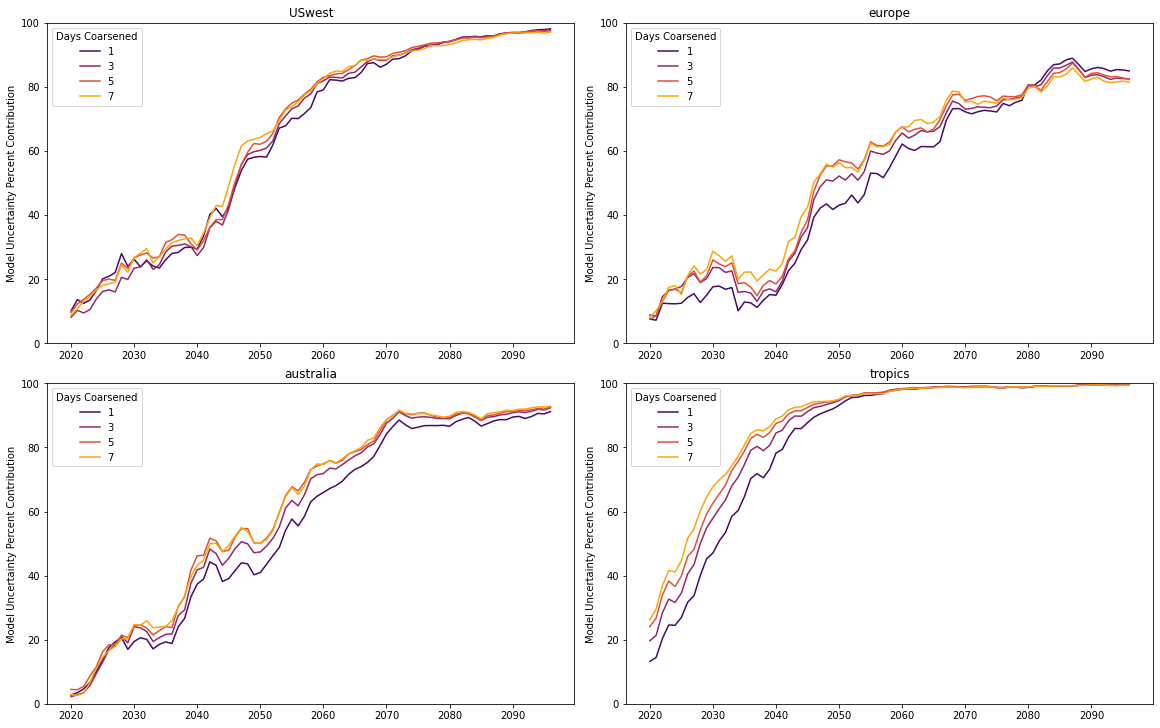

In [74]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

### Consecutive days 

In [84]:
test_conseq = sensitivity_allregions(parameter='conseq_days',
                       args= {'return_period':10,
                              'coarsen':1,
                              'conseq_days':[1,3,5,7],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

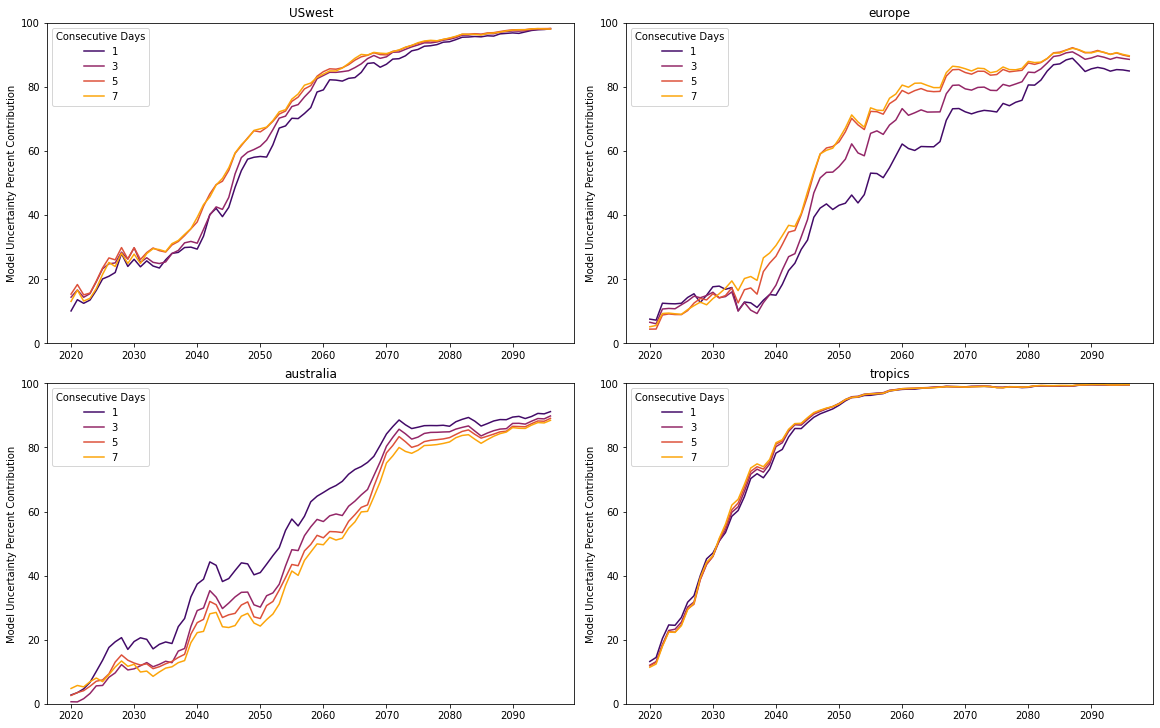

In [77]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_conseq.concat_dim):
        axe.plot(test_conseq.sel(region=r,concat_dim=m).time,test_conseq.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Consecutive Days')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

#### coarsen / consec combo

In [97]:
test_conseq = extreme_internal_allregions(
                       args= {'return_period':10,
                              'coarsen':3,
                              'conseq_days':7,
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':True
                             }
                      )

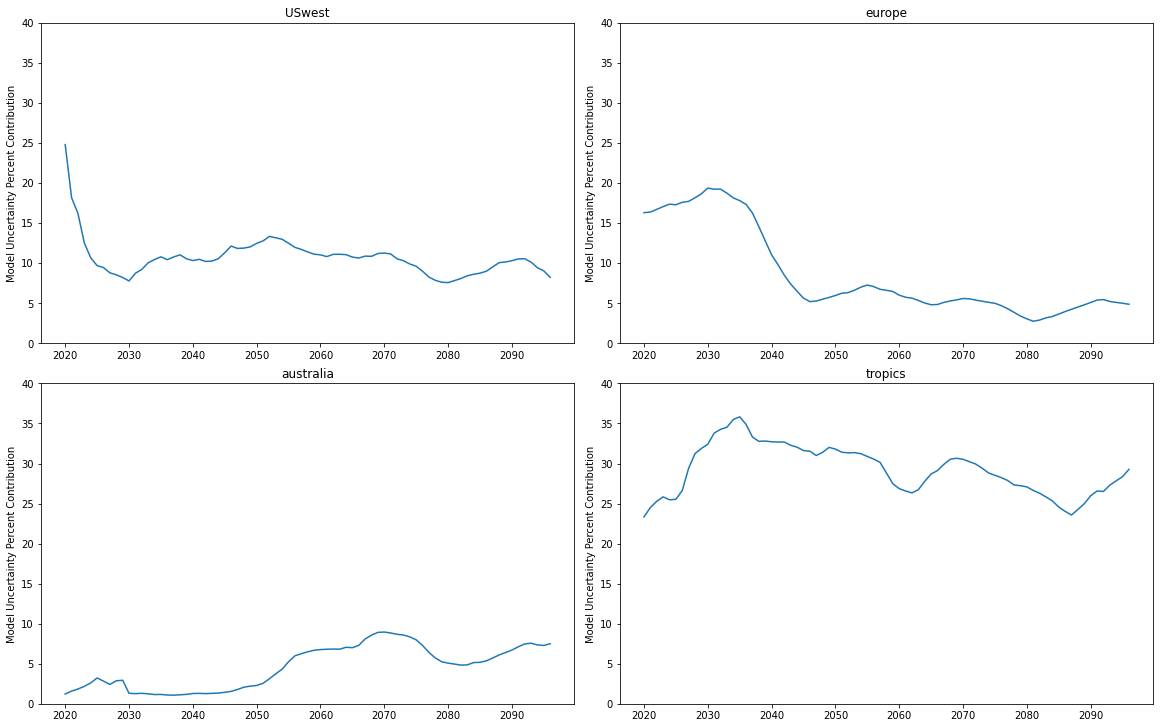

In [99]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    axe.plot(test_conseq.sel(region=r).time,test_conseq.sel(region=r).model_le_frac)
        # axe.legend(labels=labels,loc=2,title='Consecutive Days')
    axe.set_ylabel('Model Uncertainty Percent Contribution')
    axe.set_title(r)
    axe.set_ylim(0,40)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)

### rolling average

In [78]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014'),
                                                'postprocess':True
                                               }
                                     )

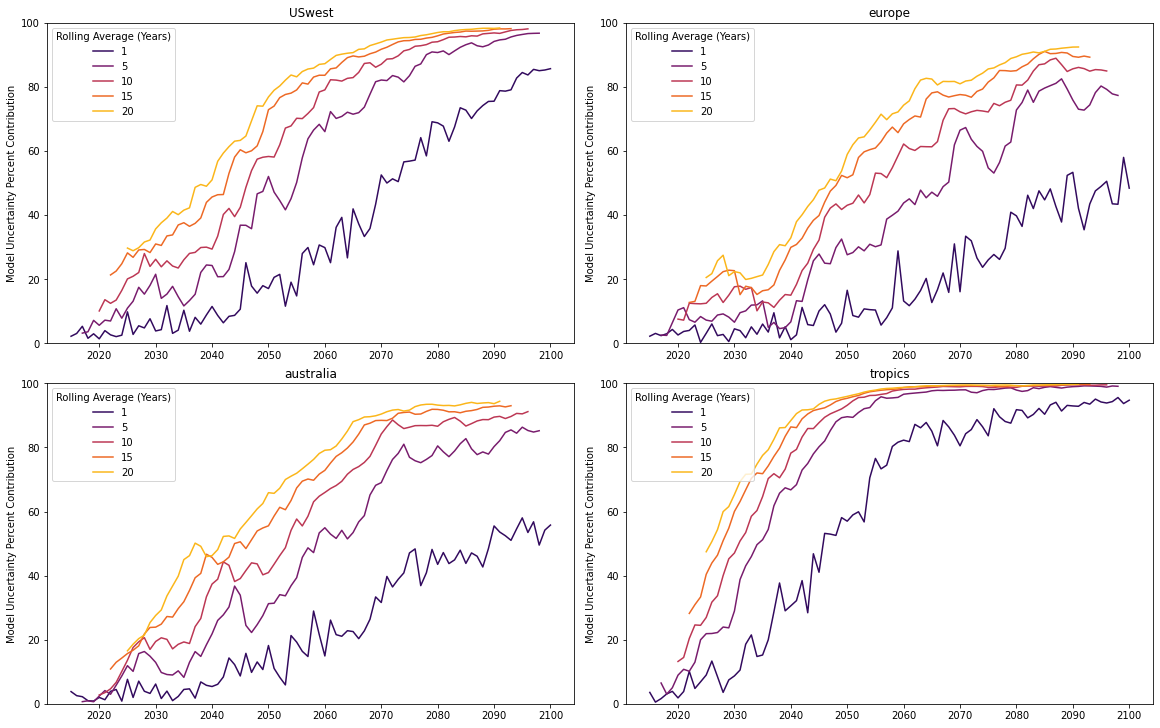

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)